In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

In [2]:
from model_generator import *

### Generate df

In [3]:
paths_dict_band = json.load(open('paths_dict_band.json', 'r'))

In [4]:
band = generate_df(paths_dict_band, 'band')

In [5]:
df = band.return_completed_df()

In [6]:
name_list_24 = ['band']

In [7]:
feature_eng_df = band.return_df_feature_engineering(name_list_24)

In [9]:
band_mean_vol_aemet = pd.read_csv('aemet/band_mean_vol_pred_aemet.csv', encoding='latin1', index_col=0)

In [12]:
final_df = feature_eng_df.merge(band_mean_vol_aemet, how='left', left_index=True, right_index=True)

In [18]:
for feature in ['pred_band_mean_aemet', 'pred_band_vol_aemet']:
    final_df[feature].fillna(method='pad', inplace=True)

### Train model

In [26]:
lgbm_model = train_model(df=final_df, output='band',
                        features_to_remove=['hour', 'weekday', 'season'],
                        n_folds=5)

In [38]:
from lightgbm import LGBMRegressor
pipeline = LGBMRegressor(num_leaves=60, learning_rate=0.09, n_estimators=1000, seed=0)

In [39]:
lgbm_model.obtain_cv_score(pipeline)

Mean absolute error: 3.0992 +- 0.1371
Mean squared error: 24.0279 +- 7.2639


In [40]:
lgbm_model.obtain_train_test_error(pipeline)

Train MAE: 0.561616524239, Train MSE: 1.1292871662
Test MAE: 2.94071451012, Test MSE: 24.1295645938


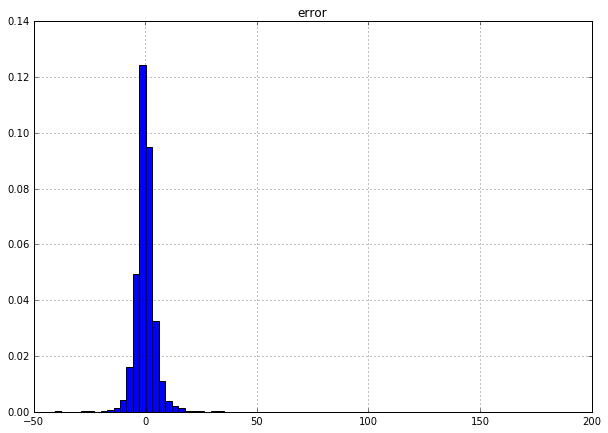

In [41]:
lgbm_model.plot_histogram_error()

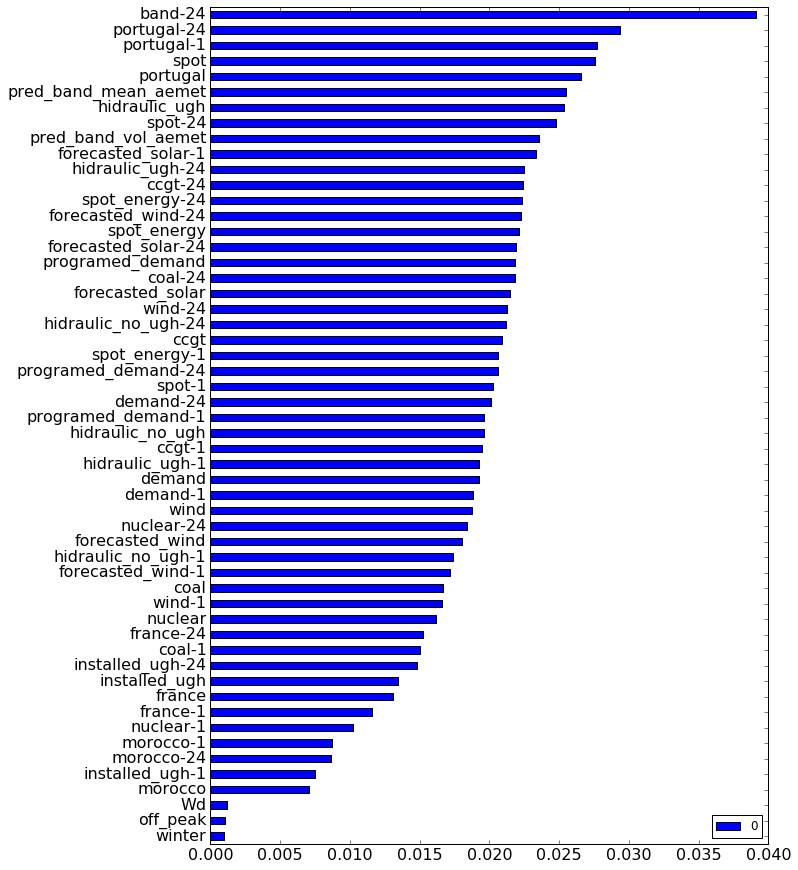

In [42]:
lgbm_model.plot_feature_importance()